<h1> Bike Sharing Demand Dataset</h1>

<h2>Forecast use of a city bikeshare system</h2>
<p/>
You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must <b>predict the <u>total count of bikes rented</u> during each hour</b> covered by the test set, using only information available prior to the rental period.
<p/>
<b>Data Fields</b>
<br/>
datetime - hourly date + timestamp<br/>
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter <br/>
holiday - whether the day is considered a holiday<br/>
workingday - whether the day is neither a weekend nor holiday<br/>
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br/>
temp - temperature in Celsius<br/>
atemp - "feels like" temperature in Celsius<br/>
humidity - relative humidity<br/>
windspeed - wind speed<br/>
casual - number of non-registered user rentals initiated<br/>
registered - number of registered user rentals initiated<br/>
count - number of total rentals<br/>

### Importing the packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns


In [0]:

import dask.dataframe as dd 

### Reading the data with pandas

In [0]:
%time                                                           # Check the time to run a particular cell

bikes = pd.read_csv('bikeshare.csv', index_col='datetime', parse_dates=True)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.82 µs


### Reading the data with Dask

In [0]:
%%timeit

bikes_dask = dd.read_csv('bikeshare.csv', parse_dates=True)

100 loops, best of 3: 17.6 ms per loop


In [0]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,count
datetime,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1


In [0]:
bikes.shape

(10886, 10)

In [0]:
# "count" is a method, so it's best to name that column something else
bikes.rename(columns={'count':'total'}, inplace=True)

In [0]:
bikes.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
total,10886.0,191.574132,181.144454,1.00,42.0000,145.000,284.0000,977.0000


### Exploratory Data Analysis

In [0]:
# Using Pandas profiling package to perform EDA

import pandas_profiling as pp

report1=pp.ProfileReport(bikes)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [0]:
report1.to_file('bikes_EDA.html')                                   # Creating HTML file of pandas-profiling report

In [0]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 10 columns):
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
total         10886 non-null int64
dtypes: float64(3), int64(7)
memory usage: 935.5 KB


**There are no missing values in the dataset**

In [0]:
corr = bikes.corr() 

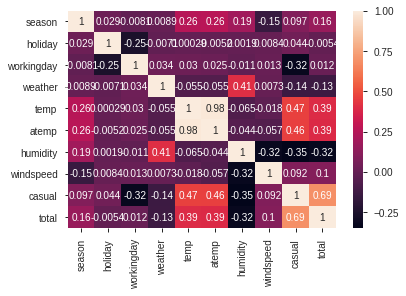

In [0]:

sns.heatmap(corr, annot=True)

**Observation** :
- atemp and temp are highly correlation. Need to remove atemp.  <br>
- There is slight correlation between temp and casual.  <br>
- There is slight correlation between temp and total.  <br>
- There is good correlation between casual and total.

### Plots

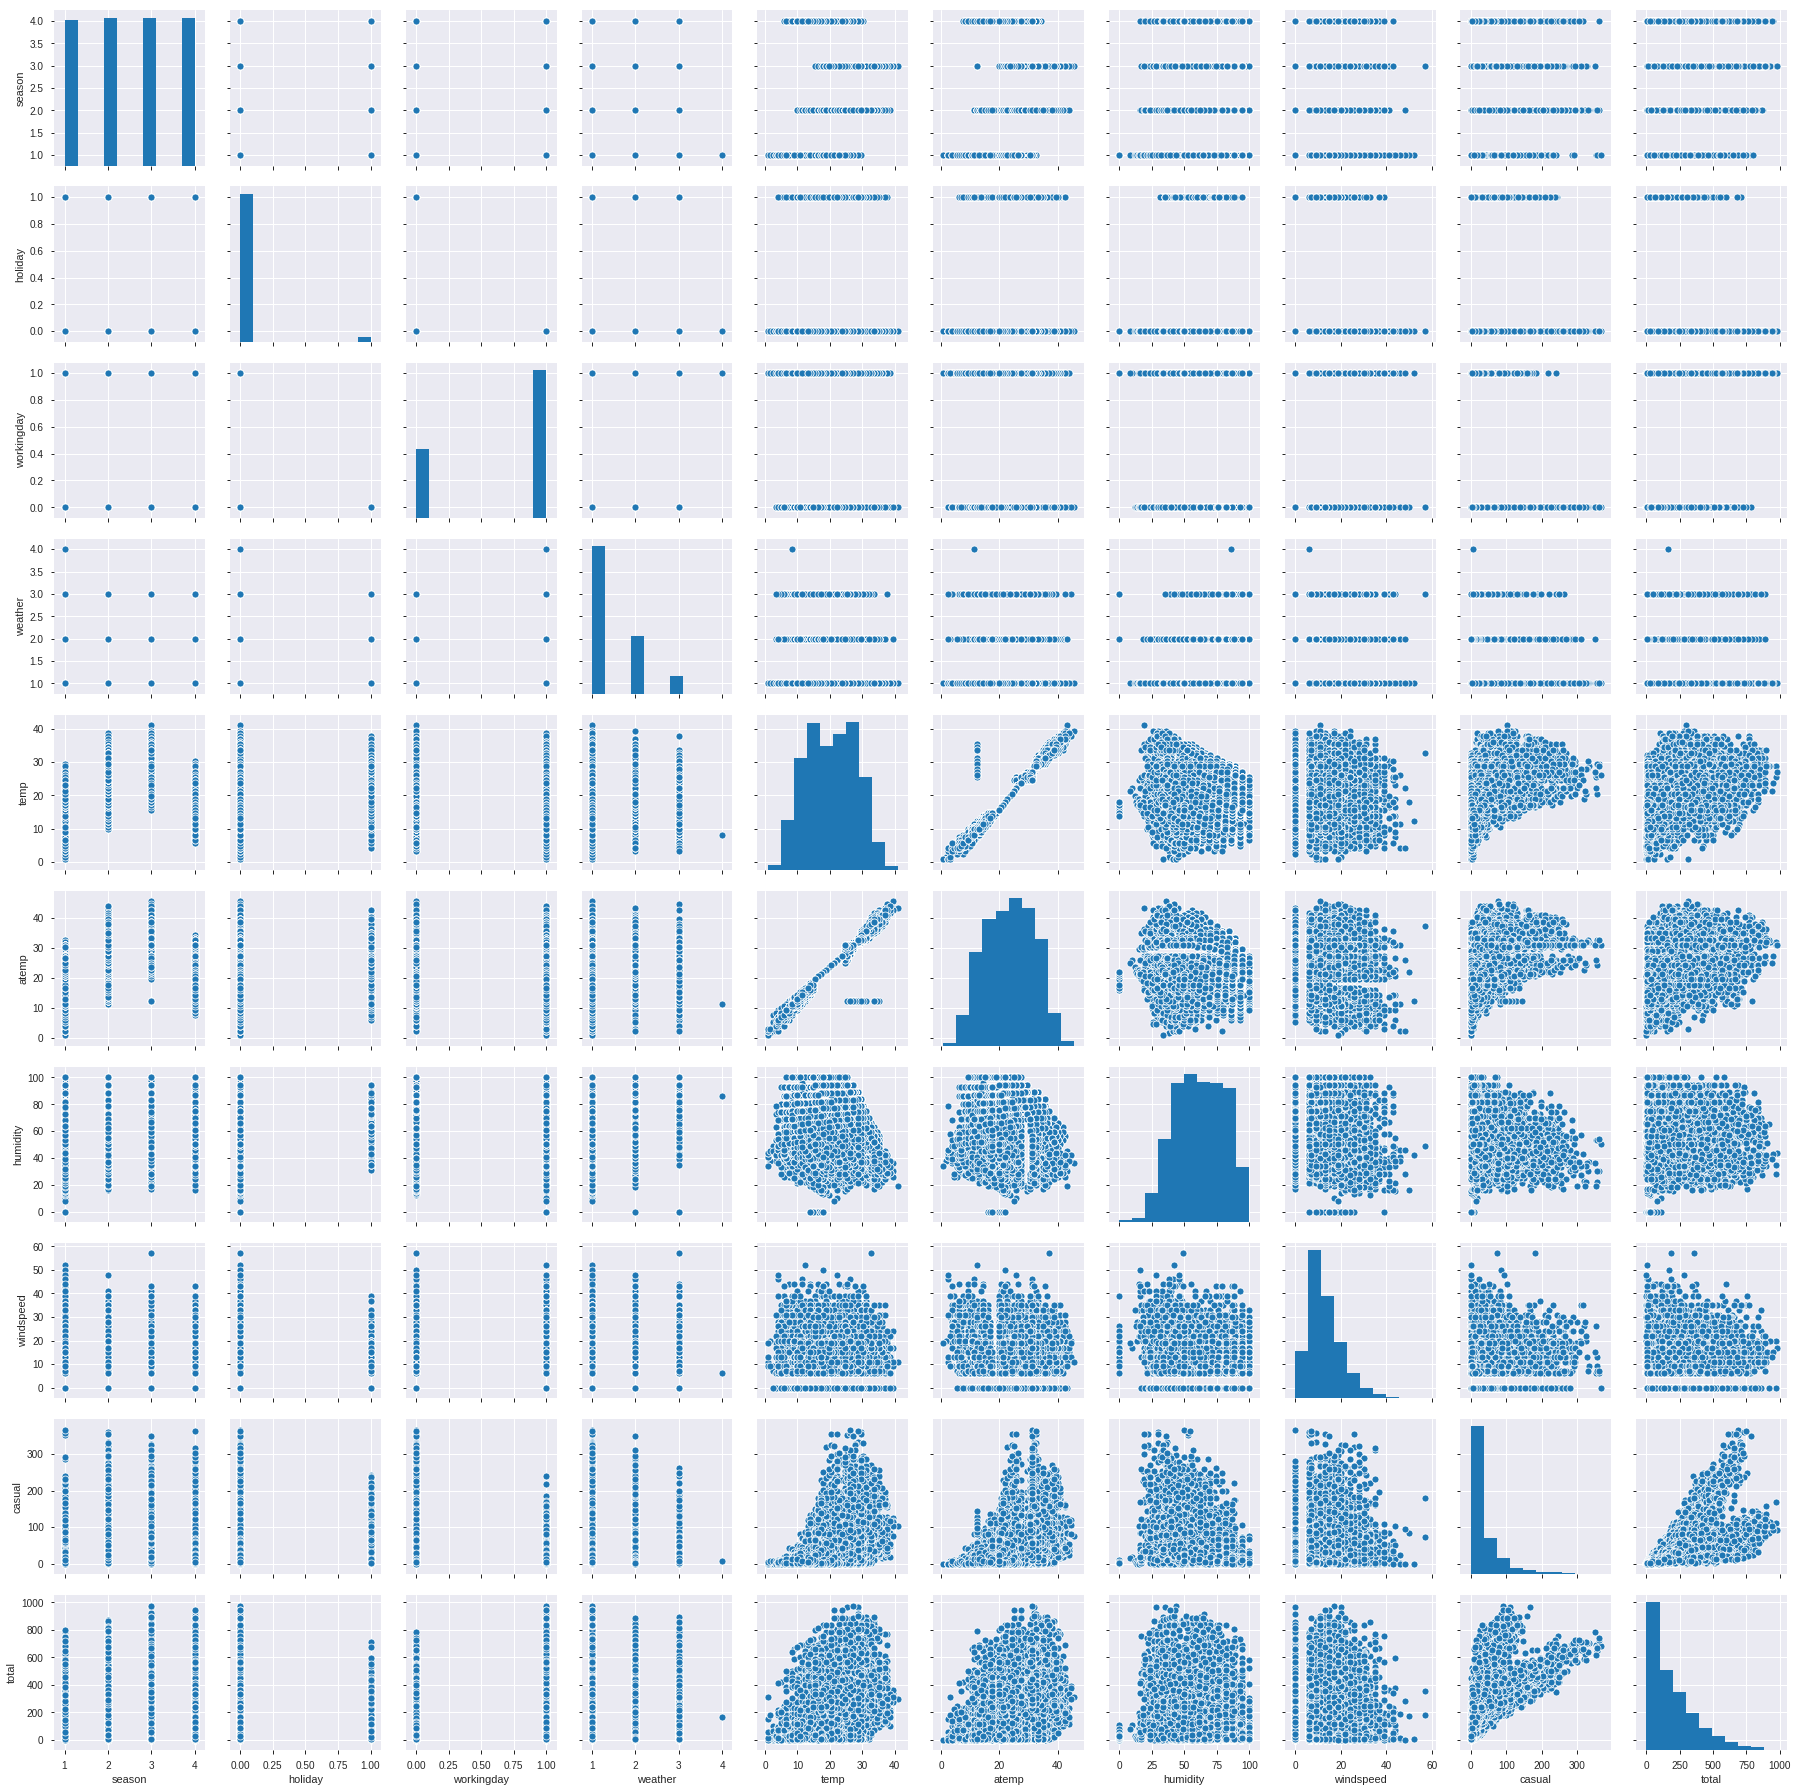

In [0]:
sns.pairplot(bikes)

**Observations**:
- There is not much correlation between plots.

**Lets observe some small correlation between temp and casual.**

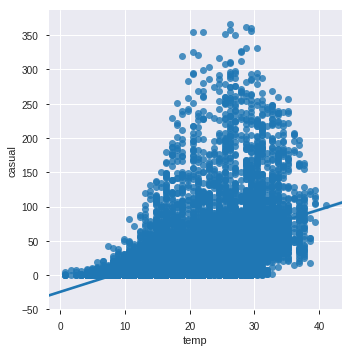

In [0]:
sns.lmplot(x='temp', y ='casual', data = bikes)

**Lets observe the correlation between temp and total.**

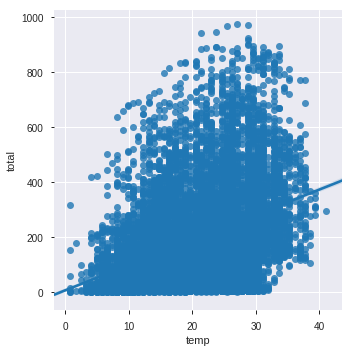

In [0]:
sns.lmplot(x='temp', y ='total', data = bikes)

### Handling Categorical data

Season and weather are categorical column.  <br>
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter <br/>
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br/>

In [0]:
cat_cols = ['season','weather']

In [0]:
season_encoded = pd.get_dummies(bikes['season'], drop_first=True, prefix = 'season')
season_encoded.head()

,season_2,season_3,season_4
datetime,,,
2011-01-01 00:00:00,0,0,0
2011-01-01 01:00:00,0,0,0
2011-01-01 02:00:00,0,0,0
2011-01-01 03:00:00,0,0,0
2011-01-01 04:00:00,0,0,0


In [0]:
weather_encoded = pd.get_dummies(bikes['weather'], drop_first=True, prefix = 'weather')
weather_encoded.head()

,weather_2,weather_3,weather_4
datetime,,,
2011-01-01 00:00:00,0,0,0
2011-01-01 01:00:00,0,0,0
2011-01-01 02:00:00,0,0,0
2011-01-01 03:00:00,0,0,0
2011-01-01 04:00:00,0,0,0


### Setting the Features and the Labels

In [0]:
bikes.shape

(10886, 10)

In [0]:
X = bikes.drop(cat_cols, axis=1)
X.shape

(10886, 8)

In [0]:
X= pd.concat([X, season_encoded, weather_encoded], axis=1)
X.shape

(10886, 14)

In [0]:
X = X.drop(['atemp', 'total'], axis=1)
X.head()

,holiday,workingday,temp,humidity,windspeed,casual,season_2,season_3,season_4,weather_2,weather_3,weather_4
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,0,0,9.84,81,0.0,3,0,0,0,0,0,0
2011-01-01 01:00:00,0,0,9.02,80,0.0,8,0,0,0,0,0,0
2011-01-01 02:00:00,0,0,9.02,80,0.0,5,0,0,0,0,0,0
2011-01-01 03:00:00,0,0,9.84,75,0.0,3,0,0,0,0,0,0
2011-01-01 04:00:00,0,0,9.84,75,0.0,0,0,0,0,0,0,0


In [0]:
y = bikes['total']

In [0]:
# Lets create our train and validation split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [0]:
!pip install tpot

     |████████████████████████████████| 81kB 5.5MB/s 
     |████████████████████████████████| 153kB 15.7MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp36-none-any.whl size=11956 sha256=ecdac1d7279b51eb2d7426f22404b2d86385232c0a8ecb9fa19025b8a063a6d5
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit


In [0]:
from tpot import TPOTRegressor

In [0]:
pipeline_optimizer = TPOTRegressor(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)


In [0]:
pipeline_optimizer.fit(X_train, y_train)

Generation 1 - Current best internal CV score: -10517.039693057077
Generation 2 - Current best internal CV score: -10517.039693057077
Generation 3 - Current best internal CV score: -10482.37816041771
Generation 4 - Current best internal CV score: -10433.049095818258
Generation 5 - Current best internal CV score: -10433.049095818258

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.5, min_samples_leaf=2, min_samples_split=7, n_estimators=100)


TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
              disable_update_check=False, early_stop=None, generations=5,
              max_eval_time_mins=5, max_time_mins=None, memory=None,
              mutation_rate=0.9, n_jobs=1, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=20,
              random_state=42, scoring=None, subsample=1.0, template=None,
              use_dask=False, verbosity=2, warm_start=False)

In [0]:
print(pipeline_optimizer.score(X_test, y_test))

-9284.67455716207


In [0]:
pipeline_optimizer.export('tpot_exported_pipeline.py')

In [0]:
# metrics

from sklearn.metrics import mean_squared_error

In [0]:
def model_train(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(name, ': Validation Data')
    mse = mean_squared_error(y_test, y_pred)
    print(name, ": RMSE")
    print("RMSE: ",np.sqrt(mse))


In [0]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(max_depth = 10, min_samples_leaf =3, random_state=101)
model_train(etr, 'ExtraTreesRegressor')

ExtraTreesRegressor : Validation Data
ExtraTreesRegressor : RMSE
RMSE:  98.1984693869127


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(max_depth = 10,  max_features=0.5, min_samples_leaf =2, min_samples_split=7, n_estimators=100, random_state=101)
model_train(etr, 'ExtraTreesRegressor')

ExtraTreesRegressor : Validation Data
ExtraTreesRegressor : RMSE
RMSE:  100.96891222160879


## Model Building

### Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
model_train(lr, 'Linear Regression')

Linear Regression : Validation Data
Linear Regression : RMSE
RMSE:  118.05631057096595


### Decision Tree Regression

In [0]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth = 10, min_samples_leaf =3, random_state=101)
model_train(dt, 'Decision Tree Regressor')

Decision Tree Regressor : Validation Data
Decision Tree Regressor : RMSE
RMSE:  106.54198537040928


In [0]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth = 5, min_samples_leaf =3, random_state=101)
model_train(dt, 'Decision Tree Regressor')

Decision Tree Regressor : Validation Data
Decision Tree Regressor : RMSE
RMSE:  103.72707371570696


### DT with gridsearch

In [0]:

from sklearn.model_selection import GridSearchCV
random_grid = {'n_estimators': range(5,20,2),
              'max_features' : ['auto', 'sqrt'],
              'max_depth' : [10,20,30,40],
              'min_samples_split':[2,5,10],
              'min_samples_leaf':[1,2,4]}


rf_gs = GridSearchCV(rf, random_grid, cv = 3, n_jobs=-1, verbose=2)

model_train(rf_gs, 'random_grid')


Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 493 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 1059 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1725 out of 1728 | elapsed:  2.4min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  2.4min finished


random_grid : Validation Data
random_grid : RMSE
RMSE:  98.2133992916277


### Random Forest Regressor

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 20, criterion='mse', max_depth = 10, min_samples_split=3, random_state=101)
model_train(rf, 'Random Forest Regressor')

Random Forest Regressor : Validation Data
Random Forest Regressor : RMSE
RMSE:  98.14997272989268


#### Randomized Grid Search

In [0]:
# run randomized search
from sklearn.model_selection import RandomizedSearchCV
#n_iter_search = 20
#random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False)


# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
model_train(param_grid, 'RandomizedSearchCV')

### XGBoost Regressor

In [0]:
from xgboost.sklearn import XGBRegressor
xgb_reg = XGBRegressor(random_state=101)
model_train(xgb_reg, "XGBoost Regressor")

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Regressor : Validation Data
XGBoost Regressor : RMSE
RMSE:  99.13436586215055


### SVM

In [0]:
from sklearn.svm import SVR
svm = SVR(gamma='scale', C=1.0, epsilon=0.2, kernel='linear')
model_train(svm, "Support Vector Machine")

Support Vector Machine : Validation Data
Support Vector Machine : RMSE
RMSE:  123.99302851487145


In [0]:
from sklearn.svm import SVR
svm = SVR(gamma='scale', C=1.0, epsilon=0.2, kernel='rbf')
model_train(svm, "Support Vector Machine")

Support Vector Machine : Validation Data
Support Vector Machine : RMSE
RMSE:  126.34640198171513


In [0]:
from sklearn.svm import SVR
svm = SVR(gamma='scale', C=1.0, epsilon=0.2, kernel='sigmoid')
model_train(svm, "Support Vector Machine")

Support Vector Machine : Validation Data
Support Vector Machine : RMSE
RMSE:  146.99953665162025


Linear kernel works better for this data

## Model Explanations

### Permutation Importance

We will run Permutation Importance on the SVM model.

In [0]:
!pip install eli5
!pip install shap
!pip install lime

     |████████████████████████████████| 102kB 3.5MB/s 
     |████████████████████████████████| 235kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.29.3-cp36-cp36m-linux_x86_64.whl size=344727 sha256=d79c06bb8f32682235a2519ae8ffceafd94dea1feadde7931f902f1c7177435c
  Stored in directory: /root/.cache/pip/wheels/00/20/87/d199e4d7397997f5494e4098104f91313ac8120753bee7b032
Successfully built shap
     |████████████████████████████████| 276kB 2.9MB/s 
  Created wheel for lime: filename=lime-0.1.1.36-cp36-none-any.whl size=284191 sha256=c8e3debc74f816538a6778c0def93b3c64eec6d8c155ed28c015680976863765
  Stored in directory: /root/.cache/pip/wheels/a9/2f/25/4b2127822af5761dab9a27be52e175105772aebbcbc484fb95
Successfully built lime


In [0]:

import eli5

from eli5.sklearn import PermutationImportance

perm = PermutationImportance(svm, random_state=101).fit(X_test, y_test)      # Evaluate the permutation importance 
eli5.show_weights(perm, feature_names = X_test.columns.values)                    # Display the weights of each features

Weight,Feature
1.0165 ± 0.0560,casual
0.0515 ± 0.0046,workingday
0.0167 ± 0.0038,season_4
0.0140 ± 0.0028,temp
0.0104 ± 0.0036,humidity
0.0013 ± 0.0017,season_3
0.0008 ± 0.0008,weather_2
0.0006 ± 0.0021,season_2
0.0000 ± 0.0000,weather_3
0 ± 0.0000,weather_4


### SHAP

Lets see how the columns impact a single record of data

In [0]:
row_to_show = 7                                                                # The row for which we want to check the SHAP explanations
data_to_predict = X_test.iloc[row_to_show]

In [0]:
data_to_preddict_array = data_to_predict.values.reshape(1,-1)

svm.predict(data_to_preddict_array)                                 # Prediction probability on the row of the data

array([83.73288271])

In [0]:
y_test.iloc[row_to_show]

141

In [0]:
import shap

# Object that can calculate Shap values
explainer = shap.KernelExplainer(svm, X_train[:10])                                       # SHAP Tree Explainer

# Calculate the shap values
shap_values = explainer.shap_values(data_to_predict)                           # SHAP explanations

### LIME

In [0]:
import lime
import lime.lime_tabular

In [0]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                         feature_names=X_train.columns.values.tolist(),
                                                         mode='regression',class_names='total')

In [0]:
lime_expln1=explainer.explain_instance(X_test.iloc[1],svm.predict, num_features=X_test.shape[1], top_labels = 1)
lime_expln1.show_in_notebook(show_table=True, show_all=False)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.13588e-30): result may not be accurate.
  overwrite_a=True).T
